## Baseline model

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

import pickle

#### 1. Load engineered features

In [16]:
# Carica i dataset processati da feature_engineering
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

print(f"📊 Dataset caricati:")
print(f"   Training set: {train.shape}")
print(f"   Test set: {test.shape}")

# Converti date_arrival in datetime
train['date_arrival'] = pd.to_datetime(train['date_arrival'])
test['date_arrival'] = pd.to_datetime(test['date_arrival'])

print(f"\n📅 Range temporale:")
print(f"   Train: {train['date_arrival'].min().date()} → {train['date_arrival'].max().date()}")
print(f"   Test: {test['date_arrival'].min().date()} → {test['date_arrival'].max().date()}")

# Visualizza prime righe
train.head()

📊 Dataset caricati:
   Training set: (39102, 41)
   Test set: (9776, 41)

📅 Range temporale:
   Train: 2004-06-15 → 2016-07-13
   Test: 2016-07-13 → 2018-10-26


,rm_id,product_id,purchase_order_id,purchase_order_item_no,receival_item_no,date_arrival,receival_status,net_weight,supplier_id,year,...,supplier_cv,rm_mean_weight,rm_std_weight,rm_count,product_mean_weight,product_std_weight,product_count,supplier_rm_combo,rm_product_combo,supplier_rm_frequency
0,357.0,91900152.0,209536.0,110.0,1,2004-06-17 09:48:00+02:00,Completed,23920.0,10001,2004,...,0.032181,24178.867925,291.959948,106,24741.157851,796.185998,3649,10001_357.0,357.0_91900152.0,106
1,357.0,91900152.0,209536.0,110.0,1,2004-06-17 09:53:00+02:00,Completed,24180.0,10001,2004,...,0.032181,24178.867925,291.959948,106,24741.157851,796.185998,3649,10001_357.0,357.0_91900152.0,106
2,357.0,91900152.0,209536.0,110.0,1,2004-06-17 12:11:00+02:00,Completed,23840.0,10001,2004,...,0.032181,24178.867925,291.959948,106,24741.157851,796.185998,3649,10001_357.0,357.0_91900152.0,106
3,357.0,91900152.0,209536.0,110.0,1,2004-06-18 07:38:00+02:00,Completed,23820.0,10001,2004,...,0.032181,24178.867925,291.959948,106,24741.157851,796.185998,3649,10001_357.0,357.0_91900152.0,106
4,357.0,91900152.0,209536.0,110.0,1,2004-06-18 09:04:00+02:00,Completed,24040.0,10001,2004,...,0.032181,24178.867925,291.959948,106,24741.157851,796.185998,3649,10001_357.0,357.0_91900152.0,106


#### 2. Feature selection

In [17]:
# Definisci le feature da usare nel modello
feature_cols = [
    # Categorical IDs
    'supplier_id', 'rm_id', 'product_id',
    
    # Temporal features
    'year', 'month', 'day_of_week', 'quarter', 'is_weekend',
    'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'days_since_start',
    
    # Supplier features
    'supplier_mean_weight', 'supplier_median_weight', 'supplier_std_weight',
    'supplier_cv', 'supplier_total_receivals',
    'weight_lag_1', 'weight_lag_3_mean', 'weight_lag_7_mean',
    'supplier_trend',
    
    # RM & Product features
    'rm_mean_weight', 'rm_std_weight', 'rm_count',
    'product_mean_weight', 'product_std_weight', 'product_count',
    'supplier_rm_frequency'
]

# Verifica che tutte le feature esistano
missing_features = [f for f in feature_cols if f not in train.columns]
if missing_features:
    print(f"⚠️ Feature mancanti: {missing_features}")
    # Rimuovi le feature mancanti
    feature_cols = [f for f in feature_cols if f in train.columns]

print(f"\n✅ Feature selezionate: {len(feature_cols)}")
print(f"📋 Lista feature:\n{feature_cols}")

# Prepara X e y
X_train = train[feature_cols]
y_train = train['net_weight']
X_test = test[feature_cols]
y_test = test['net_weight']

print(f"\n📊 Shape dei dati:")
print(f"   X_train: {X_train.shape}")
print(f"   X_test: {X_test.shape}")


✅ Feature selezionate: 29
📋 Lista feature:
['supplier_id', 'rm_id', 'product_id', 'year', 'month', 'day_of_week', 'quarter', 'is_weekend', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'days_since_start', 'supplier_mean_weight', 'supplier_median_weight', 'supplier_std_weight', 'supplier_cv', 'supplier_total_receivals', 'weight_lag_1', 'weight_lag_3_mean', 'weight_lag_7_mean', 'supplier_trend', 'rm_mean_weight', 'rm_std_weight', 'rm_count', 'product_mean_weight', 'product_std_weight', 'product_count', 'supplier_rm_frequency']

📊 Shape dei dati:
   X_train: (39102, 29)
   X_test: (9776, 29)


#### 3. Missing values management

In [18]:
# Verifica NaN nei dataset
print("🔍 Verifica valori mancanti:")
print(f"\nTrain set:")
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])
print(f"\nTest set:")
print(X_test.isnull().sum()[X_test.isnull().sum() > 0])

# Riempi eventuali NaN con 0 o median
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

print("\n✅ Valori mancanti gestiti")

🔍 Verifica valori mancanti:

Train set:
supplier_std_weight    13
rm_std_weight          16
dtype: int64

Test set:
supplier_std_weight    1
rm_std_weight          2
product_std_weight     1
dtype: int64

✅ Valori mancanti gestiti


#### 4. XGBoost

In [ ]:
print("\n" + "=" * 60)
print("🚀 XGBOOST REGRESSOR")
print("=" * 60)

# Check GPU availability
import subprocess
try:
    subprocess.check_output(['nvidia-smi'])
    gpu_available = True
    print("✅ GPU detected - using GPU acceleration")
except:
    gpu_available = False
    print("ℹ️  No GPU detected - using CPU")

# Train model - GPU optimized when available
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mae',
    tree_method='gpu_hist' if gpu_available else 'hist',  # GPU acceleration
    predictor='gpu_predictor' if gpu_available else 'auto',  # GPU prediction
    random_state=42,
    n_jobs=-1
)

print("\n⏳ Training XGBoost...")
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=10  # ✅ Rimosso eval_metric da qui
)

# Predictions
y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test = xgb_model.predict(X_test)

# Evaluate
mae_train_xgb = mean_absolute_error(y_train, y_pred_xgb_train)
mae_test_xgb = mean_absolute_error(y_test, y_pred_xgb_test)
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_pred_xgb_train))
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb_test))
r2_train_xgb = r2_score(y_train, y_pred_xgb_train)
r2_test_xgb = r2_score(y_test, y_pred_xgb_test)

print("\n📊 RISULTATI XGBOOST:")
print(f"\n   TRAINING SET:")
print(f"      MAE:  {mae_train_xgb:.2f} kg")
print(f"      RMSE: {rmse_train_xgb:.2f} kg")
print(f"      R²:   {r2_train_xgb:.4f}")

print(f"\n   TEST SET:")
print(f"      MAE:  {mae_test_xgb:.2f} kg")
print(f"      RMSE: {rmse_test_xgb:.2f} kg")
print(f"      R²:   {r2_test_xgb:.4f}")

print(f"\n   ERRORE RELATIVO: {(mae_test_xgb / y_test.mean() * 100):.2f}%")


🚀 XGBOOST REGRESSOR

⏳ Training XGBoost...
[0]	validation_0-mae:6424.15784	validation_1-mae:6758.23811
[10]	validation_0-mae:4467.69587	validation_1-mae:4566.50176
[20]	validation_0-mae:3811.29660	validation_1-mae:3797.88644
[30]	validation_0-mae:3564.16728	validation_1-mae:3538.96694
[40]	validation_0-mae:3445.74652	validation_1-mae:3460.39135
[50]	validation_0-mae:3373.72935	validation_1-mae:3450.97565
[60]	validation_0-mae:3329.99160	validation_1-mae:3477.02747
[70]	validation_0-mae:3285.59230	validation_1-mae:3453.27047
[80]	validation_0-mae:3240.03803	validation_1-mae:3439.91765
[90]	validation_0-mae:3203.54643	validation_1-mae:3426.23017
[99]	validation_0-mae:3178.75021	validation_1-mae:3435.69395

📊 RISULTATI XGBOOST:

   TRAINING SET:
      MAE:  3178.75 kg
      RMSE: 4391.90 kg
      R²:   0.6931

   TEST SET:
      MAE:  3435.69 kg
      RMSE: 4706.08 kg
      R²:   0.6780

   ERRORE RELATIVO: 26.85%


#### 5. Feature importance


📊 TOP 15 FEATURE PIÙ IMPORTANTI (XGBoost):
                 feature  importance
       weight_lag_7_mean    0.255680
          rm_mean_weight    0.225951
    supplier_mean_weight    0.101474
  supplier_median_weight    0.077490
     product_mean_weight    0.065228
     supplier_std_weight    0.035734
            weight_lag_1    0.027348
             supplier_cv    0.022968
           rm_std_weight    0.020250
supplier_total_receivals    0.018818
   supplier_rm_frequency    0.012136
                   rm_id    0.011825
      product_std_weight    0.011591
           product_count    0.011520
        days_since_start    0.011085


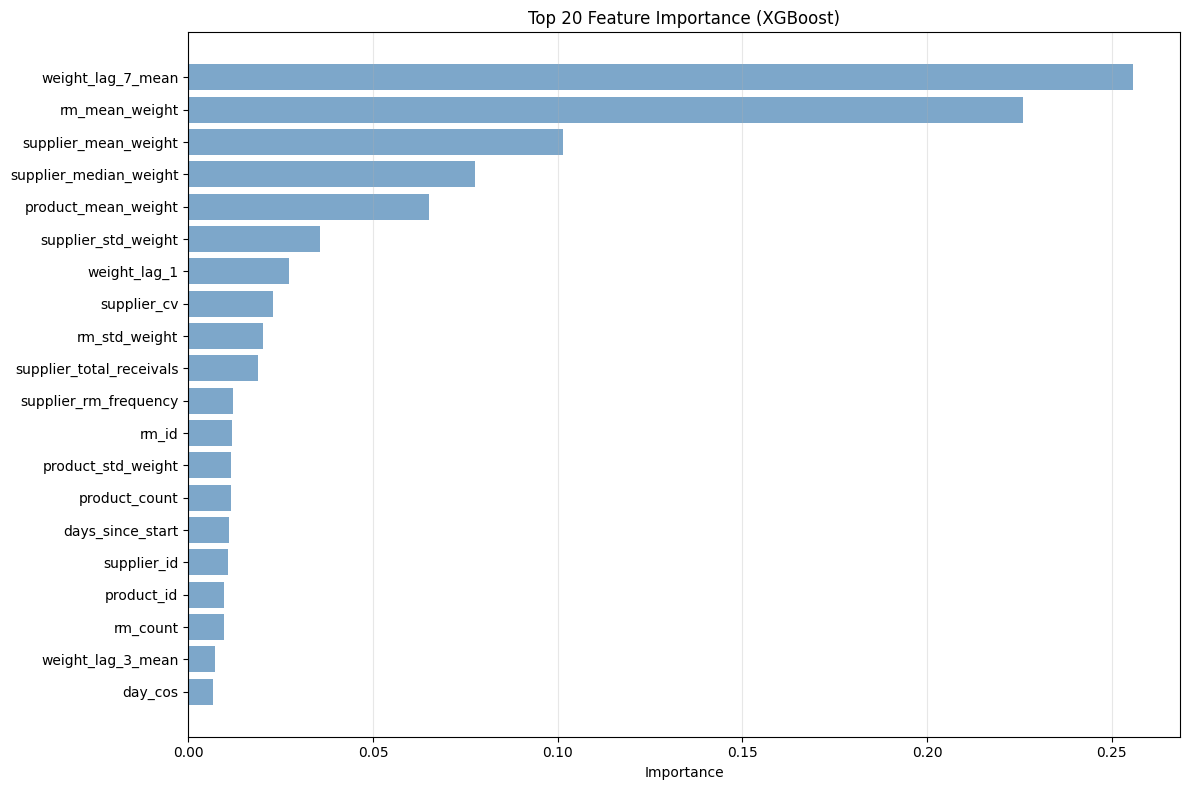

In [20]:
# Estrai feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 TOP 15 FEATURE PIÙ IMPORTANTI (XGBoost):")
print(feature_importance.head(15).to_string(index=False))

# Visualizza
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance (XGBoost)')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

#### 6. Residuals analysis

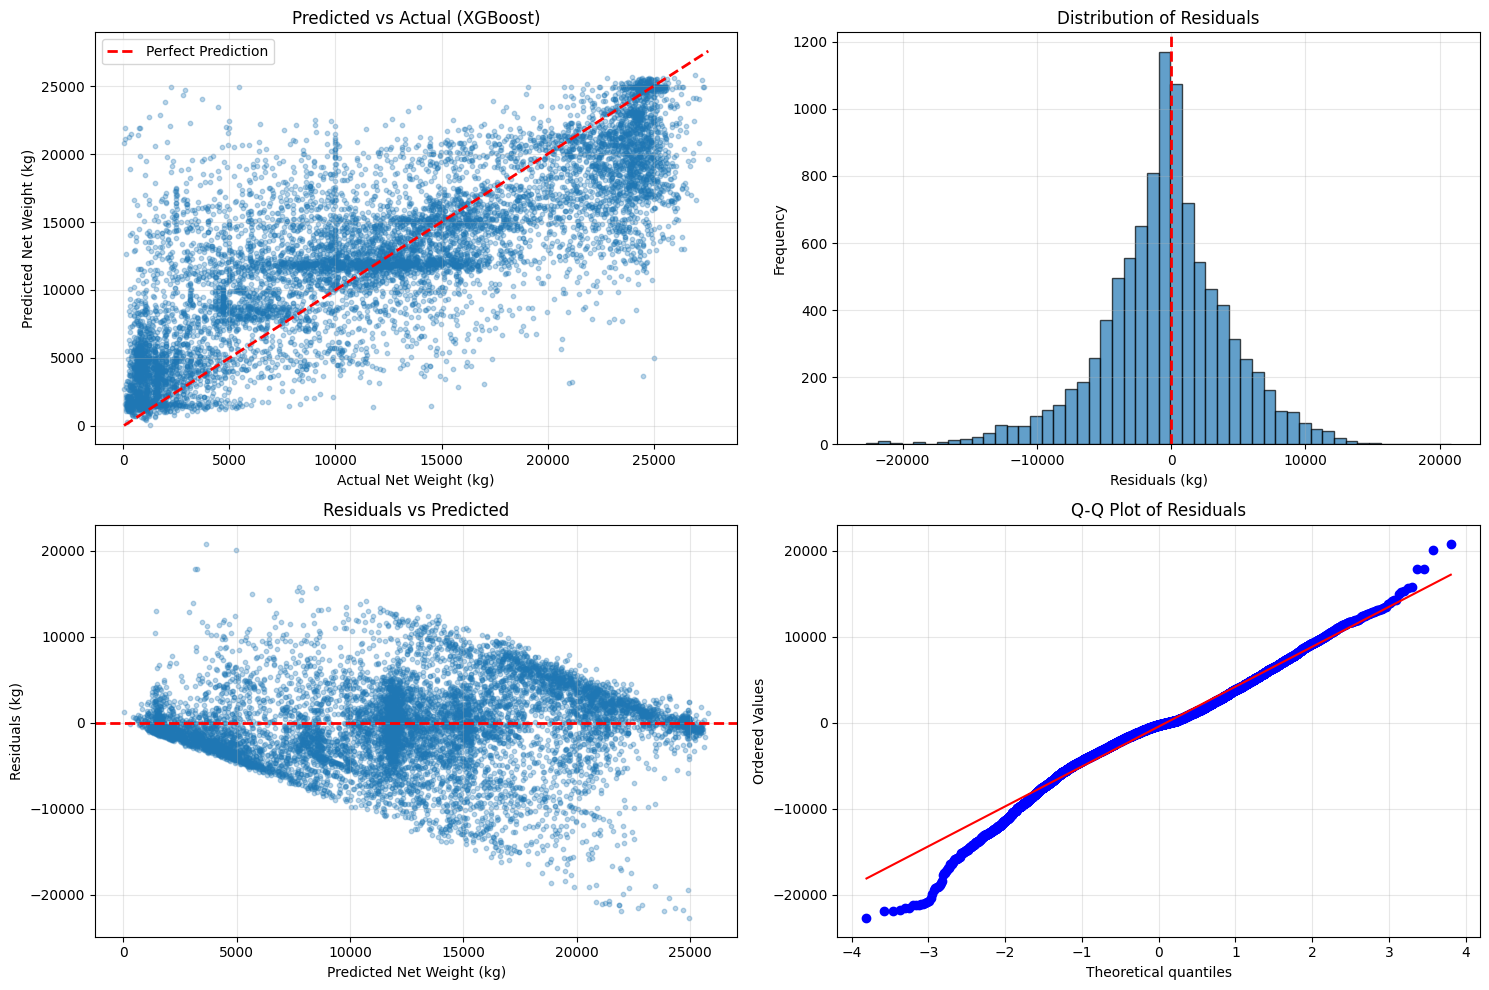


📊 STATISTICHE RESIDUI:
   Media: -446.11 kg
   Std Dev: 4685.13 kg
   Mediana: -259.89 kg
   Q1 (25%): -2934.47 kg
   Q3 (75%): 2162.66 kg


In [21]:
# Usa XGBoost (il migliore)
residuals = y_test - y_pred_xgb_test

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Predicted vs Actual
axes[0, 0].scatter(y_test, y_pred_xgb_test, alpha=0.3, s=10)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Net Weight (kg)')
axes[0, 0].set_ylabel('Predicted Net Weight (kg)')
axes[0, 0].set_title('Predicted vs Actual (XGBoost)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Residuals distribution
axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals (kg)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Residuals')
axes[0, 1].grid(alpha=0.3)

# 3. Residuals vs Predicted
axes[1, 0].scatter(y_pred_xgb_test, residuals, alpha=0.3, s=10)
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Net Weight (kg)')
axes[1, 0].set_ylabel('Residuals (kg)')
axes[1, 0].set_title('Residuals vs Predicted')
axes[1, 0].grid(alpha=0.3)

# 4. Q-Q plot residui
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Residuals')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiche residui
print("\n📊 STATISTICHE RESIDUI:")
print(f"   Media: {residuals.mean():.2f} kg")
print(f"   Std Dev: {residuals.std():.2f} kg")
print(f"   Mediana: {residuals.median():.2f} kg")
print(f"   Q1 (25%): {residuals.quantile(0.25):.2f} kg")
print(f"   Q3 (75%): {residuals.quantile(0.75):.2f} kg")

#### 7. Saving the best model

In [24]:
# Salva XGBoost
with open('models/xgboost_baseline.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

print("✅ Modello XGBoost salvato in: models/xgboost_baseline.pkl")

# Salva anche feature list
with open('models/feature_cols.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

print("✅ Lista feature salvata in: models/feature_cols.pkl")

✅ Modello XGBoost salvato in: models/xgboost_baseline.pkl
✅ Lista feature salvata in: models/feature_cols.pkl
